In [2]:
import os, sys
%pylab inline
from importlib import reload

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [4]:
# Setup the reactions in Hanna's example    
k = {(0,    (1,2)):1, # Left hand species, right hand species, rate constant
     (2,    (3,4)):0.5,
     ((1,3), 5):0.25
     }

In [ ]:
eqs = list(k.keys()) 
lhs = [list(eq[0] if type(eq[0]) is not int else [eq[0]]) for eq in eqs]
rhs = [list(eq[1] if type(eq[1]) is not int else [eq[1]]) for eq in eqs]
n_species = max([max(eq) for eq in lhs+rhs])+1

In [21]:
# Build stoichiometry matrix
A = zeros((n_species, len(eqs)))
B = zeros((n_species, len(eqs)))
for i, eq in enumerate(lhs):
    for s in eq:
        A[s, i] = 1 # Asi = 1 if species i is on the left side of equation s
for i, eq in enumerate(rhs):
    for s in eq:
        B[s, i] = 1 # Bsi = 1 if species i is on the right side of equation s

def qfun(s):
    # Form a vector consisting of the products of the concentrations of the species on the left side of each equation
    return array([prod(s[eq]) for eq in lhs])

def Hfun(s):
    return (B - A) @ diag(qfun(s))

def dsdt(s, k):
    return Hfun(s) @ k

In [ ]:
# Simulate the system

# Define the rate constants and initial conditions
rates = array([k[eq] for eq in eqs])
s0 = array([1, 1, 0, 0, 0, 0])

# Simulate the system using odeint
from scipy.integrate import odeint
t = linspace(0, 10, 100)
f = lambda s, t, *args: dsdt(s, rates)
s = odeint(f, s0, t, args=(rates,))

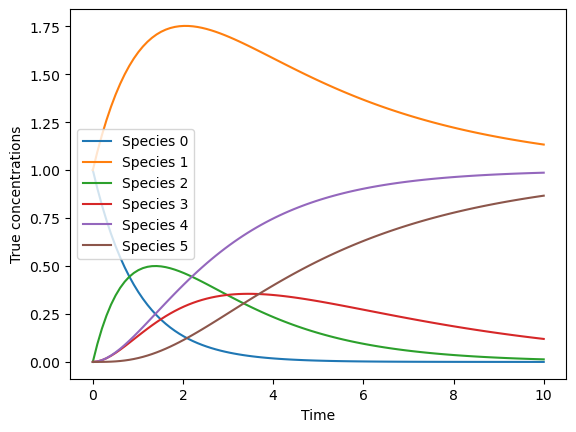

In [73]:
plot(t, s)
xlabel('Time')
ylabel('True concentrations')
legend(['Species {}'.format(i) for i in range(n_species)])
show()

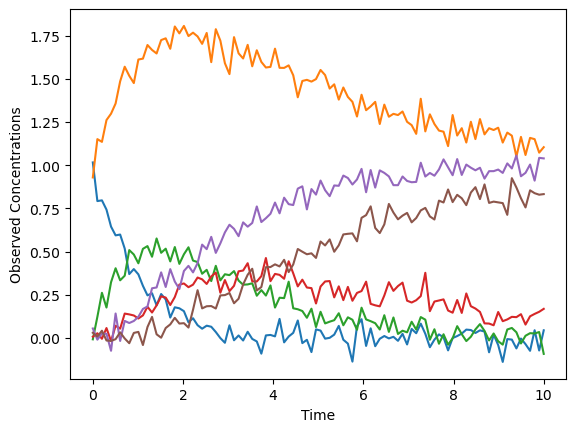

In [74]:
# Now assume we've observed those data, but with some noise
s_obs = s + 0.05*randn(*s.shape)
plot(t, s_obs)
xlabel('Time'); ylabel('Observed Concentrations'); show()

In [75]:
# Inferring the rates is a linear regression problem
def infer_rates(s_obs, t, alpha=0):
    # Infer the rates
    delta_s = s_obs[1:] - s_obs[:-1]
    delta_t = t[1:] - t[:-1]
    derivs = delta_s / delta_t[:, None]
    H0 = Hfun(s_obs[0])
    y = H0.T @ derivs[0]
    G = H0.T @ H0
    for i in range(1, len(t)-1):
        H = Hfun(s_obs[i])
        y += H.T @ derivs[i]
        G += H.T @ H
    G += alpha * eye(G.shape[0]) 
    k_est = linalg.solve(G, y)
    return k_est

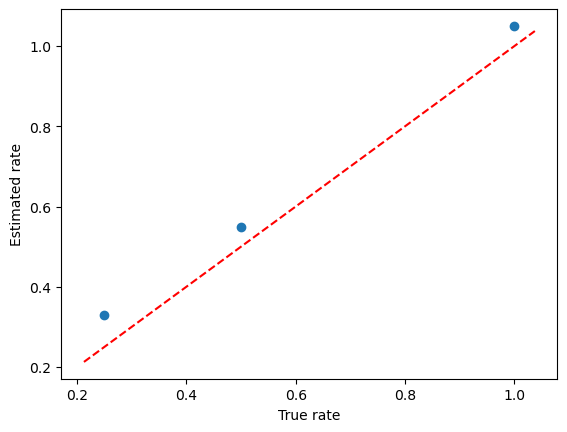

In [76]:
k_est = infer_rates(s_obs, t, alpha=2)
scatter(rates, k_est)
xlabel('True rate'); ylabel('Estimated rate'); 
plot(xlim(), xlim(), 'r--')
show()
